In [3]:
# %load source/run_bracket.py
import deepchem as dc
import numpy as np
import pickle
import json
import os
import re

keywords = [
    'RankAdjOE',
    'RankAdjDE',
    'RankAdjTempo',
    'RankAPL_Off',
    'RankAPL_Def',
    'RankeFG_Pct',
    'RankDeFG_Pct',
    'RankTO_Pct',
    'RankDTO_Pct',
    'RankOR_Pct',
    'RankDOR_Pct',
    'RankFT_Rate',
    'RankDFT_Rate',
    'RankDFT_Rate',
    'RankFG3Pct',
    'RankFG3Pct&od=d',
    'RankFG2Pct',
    'RankFG2Pct&od=d',
    'RankFTPct',
    'RankFTPct&od=d',
    'RankBlockPct',
    'RankBlockPct&od=d',
    'RankStlRate',
    'RankStlRate&od=d',
    'RankF3GRate',
    'RankF3GRate&od=d',
    'RankARate',
    'RankARate&od=d',
    'RankOff_3',
    'RankDef_3',
    'RankOff_2',
    'RankDef_2',
    'RankOff_1',
    'RankDef_1',
    'RankSOSO',
    'RankSOSD',
    'ExpRank',
    'SizeRank',
]

def get_feature_vector(html_str):
    fv = []
    for keyword in keywords:
        pattern = '%s.*>(\d+\.\d+)' % keyword
        val = re.findall(pattern, html_str)[-1]
        fv.append(float(val))
    return fv

def score_to_diff(s, neg=False):
    s = [float(x) for x in s.split('-')]
    v = abs(s[0] - s[1])
    if neg:
        return -1 * v
    return v

def get_wins_losses(html_str):
    pat = 'team.php.*?=(.*?)".*>W<.* (\d+-\d+).*\n'
    wins = re.findall(pat, html_str)
    wins = [(x[0], score_to_diff(x[1])) for x in wins]

    pat = 'team.php.*?=(.*?)".*>L<.* (\d+-\d+).*\n'
    losses = re.findall(pat, html_str)
    losses = [(x[0], score_to_diff(x[1], True)) for x in losses]
    return wins + losses

def parse_html_file(html_str):
    """
    return feature_vector, list of (oppenent, +- score)
    """
    fv = get_feature_vector(html_str)
    wl = get_wins_losses(html_str)
    return fv, wl

def get_team_dict():
    html_files = os.listdir('raw_data')
    html_files = list(filter(lambda x: x.find('2017') == -1, html_files))
    d = {}
    for html_file in html_files:
        html_str = open('raw_data/%s' % html_file).read()
        team_name = html_file[:-5]
        d[team_name] = parse_html_file(html_str)
    return d

def get_transformers():
    transformers = pickle.load(open('transformers.pkl', 'rb'))
    return transformers

def play_game(t1, t2, team_dict, keys=['27_all_data']):
    fv1 = team_dict[t1][0]
    fv2 = team_dict[t2][0]
    g1 = fv1 + fv2
    g2 = fv2 + fv1
    ds = dc.data.NumpyDataset(np.array([g1,g2]))
    for trans in get_transformers():
        ds = trans.transform(ds)
    y_pred = max_min_ensemble(predict(keys, ds))[:,0]
    final_score = y_pred[0] + -1 * y_pred[1]
    print(final_score)
    if final_score > 0:
        return t1, abs(final_score)
    return t2, abs(final_score)

def play_tourney(bracket):
    team_dict = get_team_dict()
    teams_left = bracket
    all_winners, all_scores = list(), list()
    while len(teams_left) > 1:
        print(len(teams_left))
        winners = []
        scores = []
        for i in range(0, len(teams_left), 2):
            t1, t2 = teams_left[i], teams_left[i+1]
            winner, score = play_game(t1, t2, team_dict)
            winners.append(winner)
            scores.append(score)
        teams_left = winners
        all_winners.append(winners)
        all_scores.append(scores)
    return all_winners, all_scores

def predict(keys, ds):
    retval = None
    for key in keys:
        for fold in range(5):
            model_dir = 'models/%s/%s' % (key, fold)
            model = dc.models.TensorGraph.load_from_dir(model_dir)
            y_pred = model.predict(ds)
            y_pred = np.reshape(y_pred, newshape=(y_pred.shape[0], 1))
            if retval is None:
                retval = y_pred
            else:
                retval = np.concatenate([retval, y_pred], axis=1)
    return retval

def max_min_ensemble(y_pred):
  results = []
  for row in range(y_pred.shape[0]):
    r_dat = y_pred[row, :].tolist()
    r_dat.remove(max(r_dat))
    r_dat.remove(min(r_dat))
    mean = np.mean(r_dat)
    std = np.std(r_dat)
    results.append((mean, std))
  return np.array(results)

def get_bracket(year=208):
    bracket = [
        'Virginia',
        'UMBC',
        'Creighton',
        'Kansas+St.',
        'Kentucky',
        'Davidson',
        'Arizona',
        'Buffalo',
        'Miami+FL',
        "Loyola+Chicago",
        'Tennessee',
        'Wright+St.',
        'Nevada',
        'Texas',
        'Cincinnati',
        'Georgia+St.',

        'Xavier',
        'Texas+Southern',
        'Missouri',
        'Florida+St.',
        'Ohio+St.',
        'South+Dakota+St.',
        'Gonzaga',
        'UNC+Greensboro',
        'Houston',
        'San+Diego+St.',
        'Michigan',
        'Montana',
        'Texas+A%26M',
        'Providence',
        'North+Carolina',
        'Lipscomb',

        'Villanova',
        'Radford',
        'Virginia+Tech',
        'Alabama',
        'West+Virginia',
        'Murray+St.',
        'Wichita+St.',
        'Marshall',
        'Florida',
        'UCLA',
        'Texas+Tech',
        'Stephen+F.+Austin',
        'Arkansas',
        'Butler',
        'Purdue',
        'Cal+St.+Fullerton',

        'Kansas',
        'Penn',
        'Seton+Hall',
        'North+Carolina+St.',
        'Clemson',
        'New+Mexico+St.',
        'Auburn',
        'College+of+Charleston',
        'TCU',
        'Arizona+St.',
        'Michigan+St.',
        'Bucknell',
        'Rhode+Island',
        'Oklahoma',
        'Duke',
        'Iona'
    ]
    return bracket

def run_full_bracket():
    bracket = get_bracket()
    all_winners, all_scores = play_tourney(bracket)
    print(all_winners)
    print(all_scores)
    with open('2018_final_winners.json', 'w') as fout:
        s = json.dumps(all_winners)
        fout.write(s)
    with open('2018_final_scores.json', 'w') as fout:
        s = json.dumps(all_scores)
        fout.write(s)

def play_one_game(t1, t2):
    team_dict = get_team_dict()
    retval = play_game(t1, t2, team_dict)
    return retval[0], retval[1] * 16.0


if __name__ == "__main__":
    run_full_bracket()
    #print(play_one_game('Virginia', 'Arizona'))
    #print(play_one_game('Virginia', 'Kentucky'))
    #print(play_one_game('Duke', 'Michigan+St.'))
    #print(play_one_game('Duke', 'Kansas'))
    #print(play_one_game('Radford', 'LIU+Brooklyn'))
    #print(play_one_game('Arizona+St.', 'Syracuse'))
    #print(play_one_game('St.+Bonaventure', 'UCLA'))
    #print(play_one_game('North+Carolina+Central', 'Texas+Southern'))




64
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/1/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/2/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/3/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/4/model-4375
3.0878013372421265
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/1/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/2/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/3/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/4/model-4375
0.2441622962554296
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/1/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/2/model-43

INFO:tensorflow:Restoring parameters from models/27_all_data/1/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/2/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/3/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/4/model-4375
2.2002904812494912
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/1/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/2/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/3/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/4/model-4375
-0.11610867083072662
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/1/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/2/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/3/model-437

INFO:tensorflow:Restoring parameters from models/27_all_data/2/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/3/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/4/model-4375
-0.3413139830032984
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/1/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/2/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/3/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/4/model-4375
-0.972043255964915
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/1/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/2/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/3/model-4375
INFO:tensorflow:Restoring parameters from models/27_all_data/4/model-4375

In [76]:
def reverse_ds(ds):
    X = ds.X
    y = ds.y
    y = y * -1
    l = X.shape[-1] //2
    t1 = X[:,0:l]
    t2 = X[:,l:]
    new_x = np.concatenate([t2,t1], axis=1)
    return dc.data.NumpyDataset(new_x,  y, ds.w, ds.ids)


fold=0
ds = dc.data.DiskDataset('datasets/2018_2017_folds/valid%s' % fold)
model_dir = 'models/27_all_data/%s' %  fold
model = dc.models.TensorGraph.load_from_dir(model_dir)
y_pred1 = model.predict(ds)
y_pred2 = model.predict(reverse_ds(ds)) * -1
y_pred = y_pred1 + y_pred2
y_pred = y_pred * 0.5
y_pred = np.squeeze(y_pred)

Loading dataset from disk.
INFO:tensorflow:Restoring parameters from models/27_all_data/0/model-4375


1.0547755920076165 3.1384173767811524e-05 0.719431113899955 0.0 0.01541489705998696


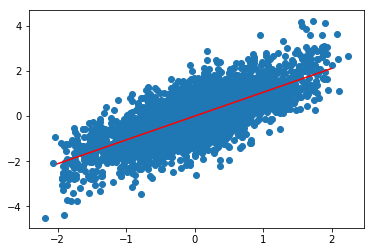

In [83]:
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
plt.scatter(y_pred, ds.y)

slope, intercept, r_value, p_value, std_err = stats.linregress(y_pred, np.squeeze(ds.y))
plt.plot([-2,2], [-2 * slope + intercept, 2 * slope + intercept], color='r')
print(slope, intercept, r_value, p_value, std_err)

1.0423951793374637 0.05270580018966453 0.7117065501699161 0.0 0.015574750718746786


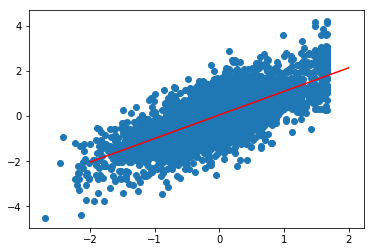

In [84]:
plt.scatter(y_pred1, ds.y)

slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(y_pred1), np.squeeze(ds.y))
plt.plot([-2,2], [-2 * slope + intercept, 2 * slope + intercept], color='r')
print(slope, intercept, r_value, p_value, std_err)

1.052257521230261 -0.053370972824131335 0.7220612398610401 0.0 0.01526175539569705


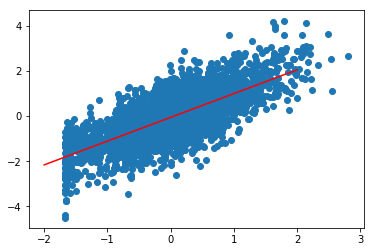

In [85]:
plt.scatter(y_pred2, ds.y)

slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(y_pred2), np.squeeze(ds.y))
plt.plot([-2,2], [-2 * slope + intercept, 2 * slope + intercept], color='r')
print(slope, intercept, r_value, p_value, std_err)

In [58]:
def correct_call(y_pred, y_true):
    right, wrong = 0,0
    for y1,y2 in zip(y_pred, y_true):
        if y1 * y2 > 0:
            right += 1
        else:
            wrong += 1
    return right / (right + wrong)
correct_call(y_pred, ds.y)

0.7416399450297756

In [86]:
correct_call(np.squeeze(y_pred1), ds.y)

0.7404947320201557

In [87]:
correct_call(np.squeeze(y_pred2), ds.y)

0.7439303710490152

0.9909039687889295 0.1008270087333561 0.9859346783088591 0.0 0.0025427190047524564


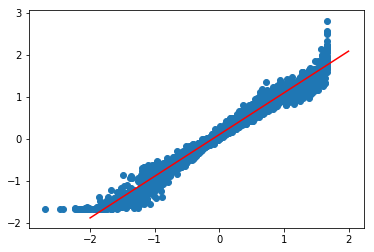

In [90]:
plt.scatter(np.squeeze(y_pred1), np.squeeze(y_pred2))
slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(y_pred1), np.squeeze(y_pred2))
plt.plot([-2,2], [-2 * slope + intercept, 2 * slope + intercept], color='r')
print(slope, intercept, r_value, p_value, std_err)

In [92]:
0.01526175539569705 * 16 # This is our stderr in points units

0.2441880863311528

In [31]:
ds.X[0][38:]

array([ 0.85775356, -0.76234697, -0.59725007, -0.17072972,  0.68255795,
        0.63758697, -0.53023096, -0.85994551,  0.12374577,  0.64674113,
       -0.86633921, -0.66796065,  0.621488  ,  0.621488  ,  0.0521532 ,
        0.0521532 , -0.79736207, -0.79736207,  1.83428112,  1.83428112,
        1.37028734,  1.37028734,  0.57027647,  0.57027647,  0.51976283,
        0.51976283, -0.39636323, -0.39636323,  0.70476595,  0.41453268,
       -0.58847696, -1.20211456, -0.40584455,  1.17227476,  0.83959883,
       -0.29149138, -0.87340203,  1.18416813])

In [33]:
rev_ds.X[0]

array([-1.32711847e+00,  1.74259929e+00,  1.81043947e-01, -4.03653786e-04,
       -5.94993442e-01, -1.44195343e+00,  3.39814240e-01,  7.65966659e-01,
       -6.94078536e-02,  8.24477423e-01,  2.00348096e+00,  3.45762999e-01,
        2.36671900e+00,  2.36671900e+00,  1.15786021e+00,  1.15786021e+00,
       -1.72603948e-01, -1.72603948e-01, -1.33791697e+00, -1.33791697e+00,
        7.24221270e-01,  7.24221270e-01, -6.65042970e-01, -6.65042970e-01,
       -5.98158421e-01, -5.98158421e-01, -1.81876767e-01, -1.81876767e-01,
       -3.63784620e-01, -5.60009582e-01,  2.81295488e-01, -6.38730881e-01,
        2.53175624e-01,  1.76781196e+00, -1.79198817e+00,  1.22321863e+00,
       -3.51258882e-01, -1.01230815e+00,  8.57753558e-01, -7.62346966e-01,
       -5.97250073e-01, -1.70729722e-01,  6.82557955e-01,  6.37586966e-01,
       -5.30230964e-01, -8.59945514e-01,  1.23745775e-01,  6.46741128e-01,
       -8.66339214e-01, -6.67960650e-01,  6.21487996e-01,  6.21487996e-01,
        5.21531992e-02,  

In [41]:
X = ds.X
l = X.shape[-1]//2
t1 = X[:,0:l]
t2 = X[:,l:]

In [42]:
t1[0]

array([-1.32711847e+00,  1.74259929e+00,  1.81043947e-01, -4.03653786e-04,
       -5.94993442e-01, -1.44195343e+00,  3.39814240e-01,  7.65966659e-01,
       -6.94078536e-02,  8.24477423e-01,  2.00348096e+00,  3.45762999e-01,
        2.36671900e+00,  2.36671900e+00,  1.15786021e+00,  1.15786021e+00,
       -1.72603948e-01, -1.72603948e-01, -1.33791697e+00, -1.33791697e+00,
        7.24221270e-01,  7.24221270e-01, -6.65042970e-01, -6.65042970e-01,
       -5.98158421e-01, -5.98158421e-01, -1.81876767e-01, -1.81876767e-01,
       -3.63784620e-01, -5.60009582e-01,  2.81295488e-01, -6.38730881e-01,
        2.53175624e-01,  1.76781196e+00, -1.79198817e+00,  1.22321863e+00,
       -3.51258882e-01, -1.01230815e+00])